In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

from logreg import LogRegCCD, generate_dataset

In [ ]:
P = 0.5
G = 0.5
D = 50
N = 500

In [ ]:
## test parameter n

In [2]:
p = 0.5
g = 0.5
d = 50
ns = [50, 100, 200, 300, 500, 1000]
N = len(ns)

n_repeats = 5

lr_rocs = []
lr_bas = []
ccd_rocs = []
ccd_bas = []

lr_rocs_std = []
lr_bas_std = []
ccd_rocs_std = []
ccd_bas_std = []

for i, n in enumerate(ns):
    print(f"{i+1}/{N}: n = {n}")

    lr_roc_vals = []
    lr_ba_vals = []
    ccd_roc_vals = []
    ccd_ba_vals = []

    for _ in range(n_repeats):
        X, y = generate_dataset(n=n, p=p, g=g, d=d)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

        lr = LogisticRegression(penalty=None, random_state=23)
        lgccd = LogRegCCD(lambda_min=1e-3)
        _, best_lambda = lgccd.optimize_lambda(X_train, y_train, X_test, y_test, measure="f1", verbose=1)

        lr.fit(X_train, y_train)
        lr_y_probs = lr.predict_proba(X_test)[:,1]
        lr_preds = (lr_y_probs >= 0.5).astype(int)

        lr_roc_vals.append(roc_auc_score(y_test, lr_y_probs))
        lr_ba_vals.append(balanced_accuracy_score(y_test, lr_preds))

        lgccd.fit(X_train, y_train, best_lambda)
        ccd_roc_vals.append(lgccd.validate(X_test, y_test, measure='roc_auc'))
        ccd_ba_vals.append(lgccd.validate(X_test, y_test, measure='balanced_accuracy'))

    lr_rocs.append(np.mean(lr_roc_vals))
    lr_bas.append(np.mean(lr_ba_vals))
    ccd_rocs.append(np.mean(ccd_roc_vals))
    ccd_bas.append(np.mean(ccd_ba_vals))

    lr_rocs_std.append(np.std(lr_roc_vals))
    lr_bas_std.append(np.std(lr_ba_vals))
    ccd_rocs_std.append(np.std(ccd_roc_vals))
    ccd_bas_std.append(np.std(ccd_ba_vals))

1/6: n = 50


100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


2/6: n = 100


100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


3/6: n = 200


100%|██████████| 100/100 [00:15<00:00,  6.64it/s]


4/6: n = 300


100%|██████████| 100/100 [00:16<00:00,  5.99it/s]


5/6: n = 500


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


6/6: n = 1000


100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


In [3]:
data = {
    'n': ns,
    'lr_rocauc': lr_rocs,
    'lr_rocauc_std': lr_rocs_std,
    'lr_balancedaccuracy': lr_bas,
    'lr_balancedaccuracy_std': lr_bas_std,
    'ccd_rocauc': ccd_rocs,
    'ccd_rocauc_std': ccd_rocs_std,
    'ccd_balancedaccuracy': ccd_bas,
    'ccd_balancedaccuracy_std': ccd_bas_std
}

df = pd.DataFrame(data)
df.set_index('n', inplace=True)
print(df)

      lr_rocauc  lr_rocauc_std  lr_balancedaccuracy  lr_balancedaccuracy_std  \
n                                                                              
50     0.649423       0.085071             0.619762                 0.069919   
100    0.653189       0.097341             0.615669                 0.075124   
200    0.639502       0.043096             0.587243                 0.060589   
300    0.677850       0.049548             0.617543                 0.048212   
500    0.724463       0.028444             0.662024                 0.014399   
1000   0.723471       0.031946             0.672101                 0.030770   

      ccd_rocauc  ccd_rocauc_std  ccd_balancedaccuracy  \
n                                                        
50      0.721349        0.124863              0.671667   
100     0.746506        0.047894              0.659622   
200     0.745642        0.024745              0.685599   
300     0.749817        0.071534              0.690571   
500     0.7

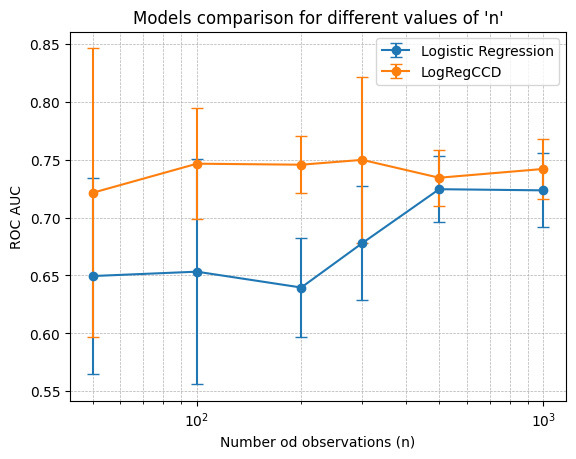

In [4]:
plt.errorbar(ns, lr_rocs, yerr=lr_rocs_std, label="Logistic Regression", fmt='-o', capsize=4)
plt.errorbar(ns, ccd_rocs, yerr=ccd_rocs_std, label="LogRegCCD", fmt='-o', capsize=4)

plt.xlabel("Number od observations (n)")
plt.ylabel("ROC AUC")
plt.xscale("log")
plt.legend()
plt.title("Models comparison for different values of 'n'")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


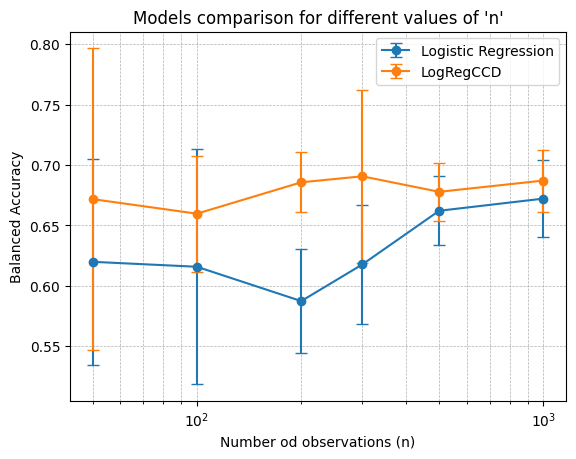

In [5]:
plt.errorbar(ns, lr_bas, yerr=lr_rocs_std, label="Logistic Regression", fmt='-o', capsize=4)
plt.errorbar(ns, ccd_bas, yerr=ccd_rocs_std, label="LogRegCCD", fmt='-o', capsize=4)
plt.xlabel("Number od observations (n)")
plt.ylabel("Balanced Accuracy")
plt.xscale("log")
plt.legend()
plt.title("Models comparison for different values of 'n'")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


In [ ]:
## big number of variables

In [ ]:
p = 0.5
g = 0.5
ns = [100, 200, 300, 500, 1000]
ds = [int(nn / 2) for nn in ns]
N = len(ns)

n_repeats = 5

lr_rocs = []
lr_bas = []
ccd_rocs = []
ccd_bas = []

for i, (n,d) in enumerate(zip(ns,ds)):
    print(f"{i+1}/{N}: n = {n}")

    lr_roc_vals = []
    lr_ba_vals = []
    ccd_roc_vals = []
    ccd_ba_vals = []

    for _ in range(n_repeats):
        X, y = generate_dataset(n=n, p=p, g=g, d=d)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=23)

        lr = LogisticRegression(penalty=None, random_state=23)
        lgccd = LogRegCCD(lambda_min=1e-3)
        _, best_lambda = lgccd.optimize_lambda(X_train, y_train, X_test, y_test, measure="roc_auc", verbose=1)
        print(best_lambda)

        lr.fit(X_train, y_train)
        lr_y_probs = lr.predict_proba(X_test)[:,1]
        lr_preds = (lr_y_probs >= 0.5).astype(int)

        lr_roc_vals.append(roc_auc_score(y_test, lr_y_probs))
        lr_ba_vals.append(balanced_accuracy_score(y_test, lr_preds))

        lgccd.fit(X_train, y_train, best_lambda)
        ccd_roc_vals.append(lgccd.validate(X_test, y_test, measure='roc_auc'))
        ccd_ba_vals.append(lgccd.validate(X_test, y_test, measure='balanced_accuracy'))

    lr_rocs.append(np.mean(lr_roc_vals))
    lr_bas.append(np.mean(lr_ba_vals))
    ccd_rocs.append(np.mean(ccd_roc_vals))
    ccd_bas.append(np.mean(ccd_ba_vals))

1/8: n = 100


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


0.04328761281083057


100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


0.24770763559917108


100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


0.10722672220103231


100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


0.026560877829466867


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


0.11497569953977356
2/8: n = 200


100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


0.05722367659350217


100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


0.2656087782946686


100%|██████████| 100/100 [00:34<00:00,  2.91it/s]


0.0533669923120631


100%|██████████| 100/100 [00:36<00:00,  2.72it/s]


0.12328467394420659


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


0.1
3/8: n = 300


100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


0.24770763559917108


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


0.093260334688322


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


0.08111308307896872


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


0.12328467394420659


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


0.23101297000831597
4/8: n = 500


100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


0.07564633275546287


100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


0.05722367659350217


100%|██████████| 100/100 [03:12<00:00,  1.92s/it]


0.0657933224657568


100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


0.040370172585965536


100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


0.2656087782946686
5/8: n = 1000


  0%|          | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

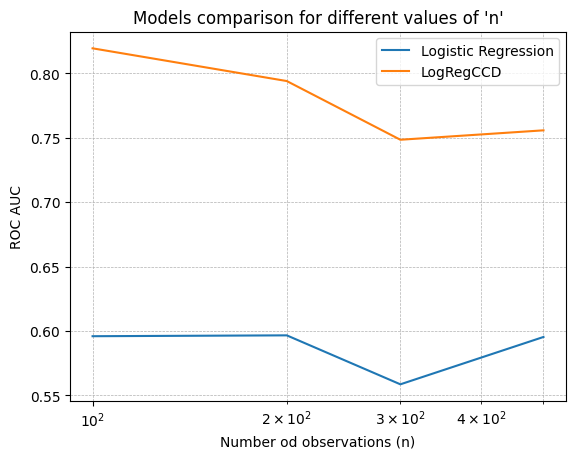

In [56]:
plt.plot(ns[:4], lr_rocs, label="Logistic Regression")
plt.plot(ns[:4], ccd_rocs, label="LogRegCCD")
plt.xlabel("Number od observations (n)")
plt.ylabel("ROC AUC")
plt.xscale("log")
plt.legend()
plt.title("Models comparison for different values of 'n'")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

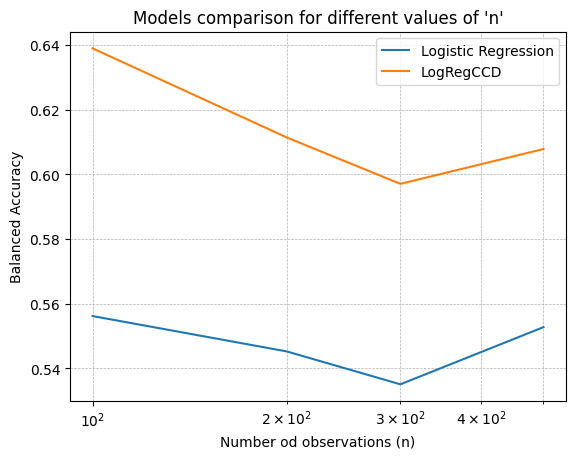

In [57]:
plt.plot(ns[:4], lr_bas, label="Logistic Regression")
plt.plot(ns[:4], ccd_bas, label="LogRegCCD")
plt.xlabel("Number od observations (n)")
plt.ylabel("Balanced Accuracy")
plt.xscale("log")
plt.legend()
plt.title("Models comparison for different values of 'n'")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()